$\chi_{\perp}^{2h}$


$\xi = (r/r_0)^{\gamma}$


$\chi_{\perp} = \int \xi ds$

rate of incidence = $\lambda$



$f_c = 1 - \exp(-\lambda)$

$\lambda = (1 + [\Sigma \chi_i])~\langle dN/dz | C_0, \alpha \rangle \delta z$

$\langle dN/dz\rangle = C_0(1 + z)^{\alpha}$

$(...) = (R_{\perp}, M | r_0, \gamma, \beta)$

$\chi^{100}(...) \chi^{200}(...) \chi^{300}(...) \chi^{400}(...) \chi^{500}(...)$

In [38]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table, vstack
from cgmsquared import load_cgmsquared
import numpy as np
from astropy.cosmology import Planck15 as cosmo
import casbah.gal_properties as caprop
import haloclustering.data as datamodule
import cgmsquared.clustering2 as c2
import pickle
import os
from astropy.cosmology import Planck15 as cosmo
import pandas as pd
import glob
from cgmsquared import clustering as cgm2_cluster
import scipy


plt.rcParams['font.serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
noncompact_df = pd.read_csv("/Users/mwilde/Downloads/cgm2_casbah_velo_split_table.csv")
noncompact_df['log_rho'] = np.log10(noncompact_df.rho)
noncompact_df.sort_values('rho', inplace=True)

# galaxy data
rho_com = noncompact_df.rho.values/1000
z = noncompact_df['z'].values
Hz = cosmo.H(z).value
outcomes = noncompact_df.filter(like='HM_').drop(columns="HM_0_500")
hits = outcomes.values == 'hit'
misses = outcomes.values == 'miss'


In [103]:
def chi_perp_vlist(r0, gamma, dvlist):
    chi_list = []
    chidv_last = 0
    dvlast = 0
    for dv in dvlist:
        chi = c2.chi_perp_analytic(r0, gamma, rho_com, z, Hz, dv)
        chidv = chi*dv
        chi_list.append((chidv - chidv_last)/(dv - dvlast))
        chidv_last = chidv
        dvlast = dv
    
    chi_arr = np.array(chi_list)

    return chi_arr.T

def mean_dNdz(dndz_coeff, dndz_index, vmax=100.):
    # dN_dz for HI with logNHI > 14
    ion_lz = cgm2_cluster.hi_lz(
        z, danforth=False, gamma=dndz_index, coeff=dndz_coeff)
    clight = 299792.458
    # mean number of absorbers along line of sight in dz window
    dz = (1 + z) * (2 * vmax / clight)
    mean_dN_dz = ion_lz * dz  # ~ (1+z)^3.3
    return mean_dN_dz


def phit(chi_arr, mean_dNdz):
    rate_of_incidence = (1 + chi_arr) * mean_dNdz[:, None]
    prob_miss = np.exp(-rate_of_incidence)
    prob_hit = 1 - prob_miss
    prob_hit = np.clip(prob_hit, 0.00001, 0.99)
    return prob_hit

def log_likelihood(params):
    r0, gamma, dndz_coeff, dndz_index = params

    chi_arr = chi_perp_vlist(r0, gamma, dvlist)
    meandNdz = mean_dNdz(dndz_coeff, dndz_index)
    prob_hit = phit(chi_arr, meandNdz)
    prob_miss = 1 - prob_hit
    log_prob_hits = np.log(prob_hit[hits])
    log_prob_miss = np.log(prob_miss[misses])

    sum_log_prob_miss = np.sum(log_prob_miss)
    sum_log_prob_hits = np.sum(log_prob_hits)

    llikelihood = sum_log_prob_hits + sum_log_prob_miss
    return llikelihood

def log_prior(params):
    """the Bayesian prior. Will change with each model based on which params are 
    important to the model. 

    Returns:
        ln_prior (float): natural log of the prior
    """
    r0, gamma, dndz_coeff, dndz_index = params

    # flat prior on r0, gaussian prior on gamma around 1.6

    if (r0 < 0) or (r0 > 10):
        return -np.inf
    if (gamma < 0) or (gamma > 10):
        return -np.inf
    if (
        (dndz_index < -3)
        or (dndz_index > 3)
        or (dndz_coeff < 0)
        or (dndz_coeff > 40)
    ):
        return -np.inf

    ln_prior = -0.5 * ((gamma - 1.7) ** 2 / (0.1) ** 2)  # tejos 2014
    ln_prior += -0.5 * ((r0- 3.8) ** 2 / (0.3) ** 2)  # tejos 2014
    # ln_prior += -0.5*((beta - 0.5)**2/(sig)**2)
    ln_prior += -0.5 * ((dndz_index - 0.97) ** 2 / (0.87) ** 2)  # kim+
    ln_prior += -0.5 * (
        (np.log(dndz_coeff) - np.log(10) * 1.25) ** 2 / (np.log(10) * 0.11) ** 2
    ) - np.log(
        dndz_coeff
    )  # kim+ # log-normal has a 1/x

    return ln_prior

def log_probability(params):
    lp = log_prior(params)

    if not np.isfinite(lp):
        return -np.inf
    logprob = lp + log_likelihood(params)
    return logprob

In [119]:
# params
r0 = 3.6
gamma = 1.7
dndz_index = 1.5
dndz_coeff = 18

# params = (r0, gamma, r0_2, gamma_2, beta, beta2h, dndz_index, dndz_coeff)
params = (r0_2, gamma_2, dndz_index, dndz_coeff)
dv_chunk = 100
dvlist = np.arange(100, 501, dv_chunk)


chi_arr = chi_perp_vlist(r0, gamma, dvlist)
meandndz = mean_dNdz(dndz_index=dndz_index, dndz_coeff=dndz_coeff)
covfrac = phit(chi_arr, meandndz)
logprob = log_probability(params)

In [122]:
%%timeit
# A(r0, γ ) = r^γ Gamma(1/2) Gamma[(γ − 1)/2]/ (γ/2)
3.8**5, scipy.special.gamma(1/2) * scipy.special.gamma((1.6-1)/2) / scipy.special.gamma(1.6/2) 

65.4 µs ± 1.76 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


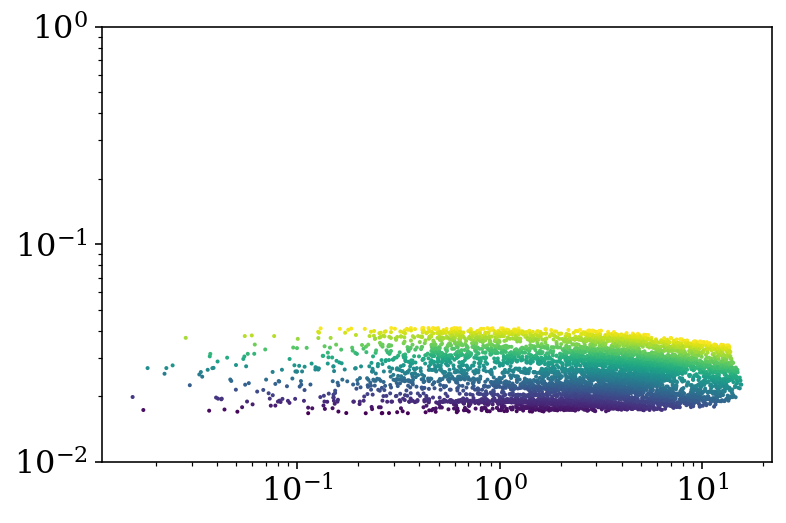

In [101]:
plt.scatter(rho_com, covfrac[:,4], s=1, c=z);
plt.yscale('log');
plt.ylim(1e-2, 1)
plt.xscale('log')



In [112]:
import haloclustering.evalulate_model as evaluate
initial = np.array([3.8, 1.7, 18, 1.5])
sampler = evaluate.posterior_sampler(initial, log_probability, nsteps=4000, solnisobject=False)

100%|██████████| 4000/4000 [11:12<00:00,  5.95it/s]


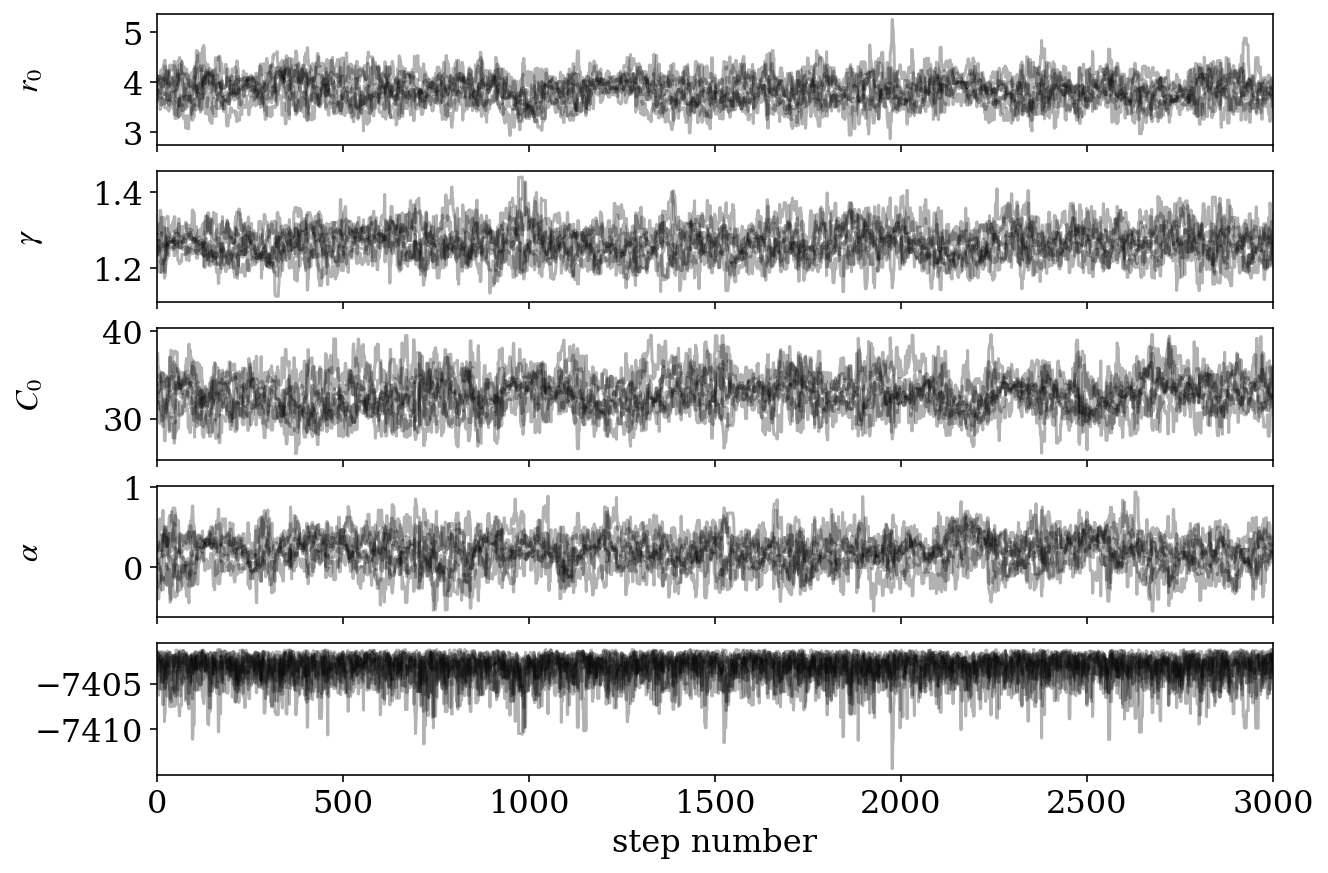

In [115]:
discard = 1000
samples = sampler.get_chain(discard=discard)
flat_samples = sampler.get_chain(discard=discard, thin=1, flat=True)
ndim = samples.shape[2]

# plot
fig, axes = plt.subplots(nrows=ndim+1, figsize=(10, 7), sharex=True)
labels = [r"$r_0$", r"$\gamma$", r'$C_0$', r'$\alpha$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

axes[-1].plot(sampler.lnprobability.T[discard:], "k", alpha=0.3);

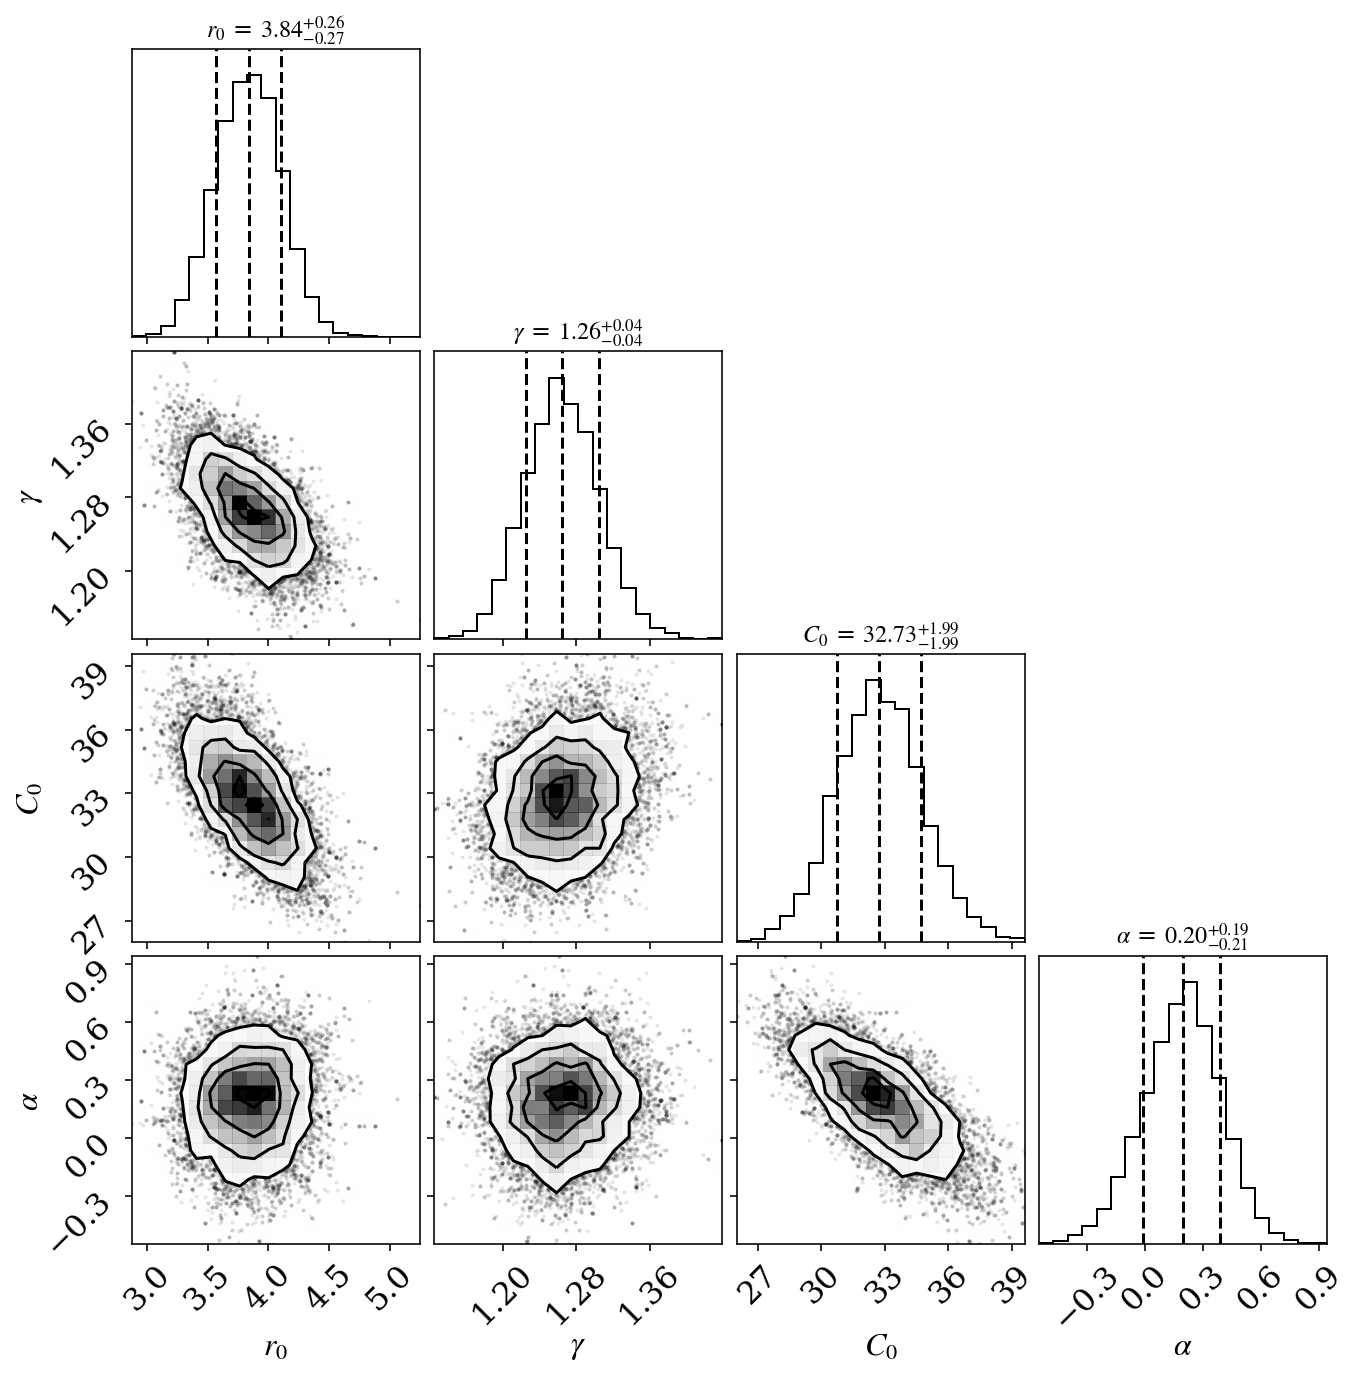

In [116]:
import corner
fig = corner.corner(
    flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}
);
fig.savefig('corner_velocity_single_powerlaw.png')

In [118]:
np.median(flat_samples, axis=0)

array([ 3.83936011,  1.26462759, 32.7259534 ,  0.19868885])